In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaincc
from scipy.stats.distributions import chi2
import scipy.optimize as op
import pandas as pd

In [2]:
plt.rcParams.update({'font.size':20})

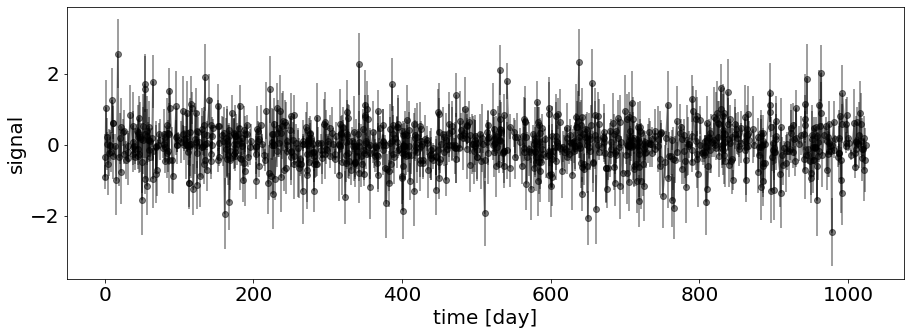

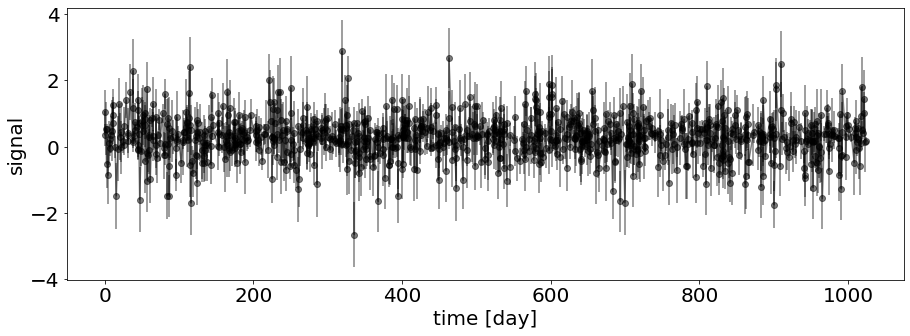

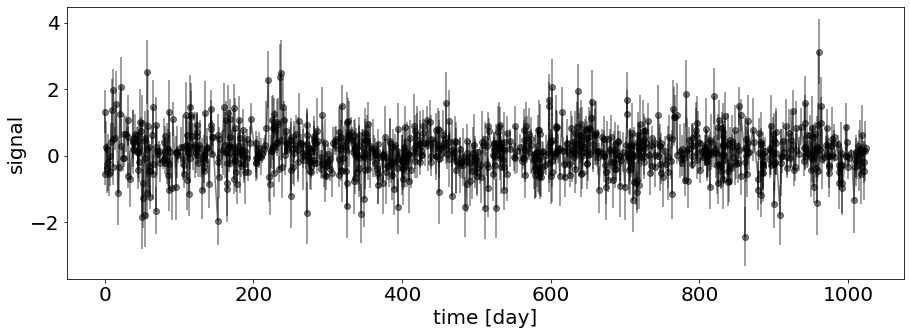

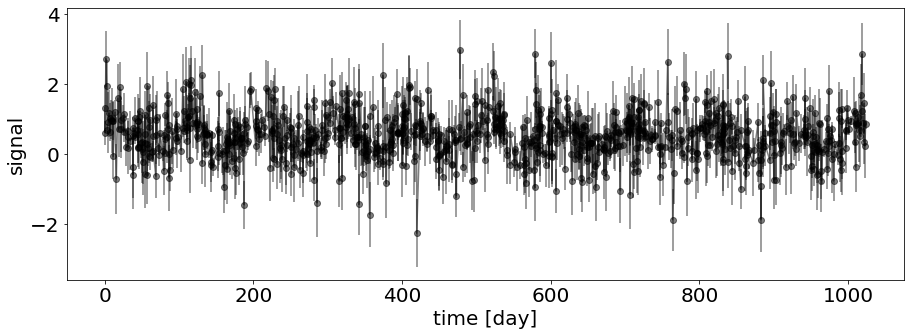

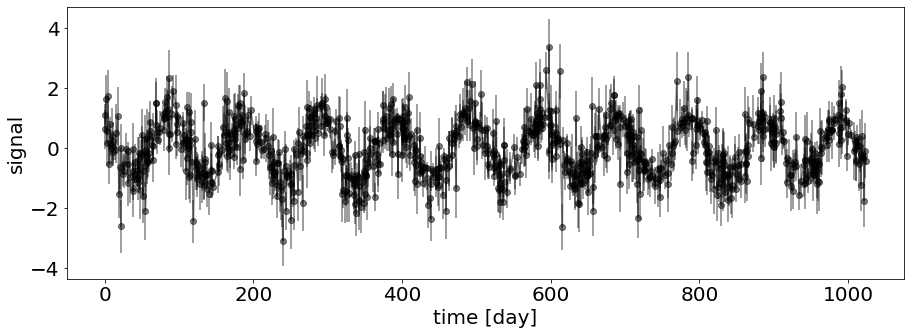

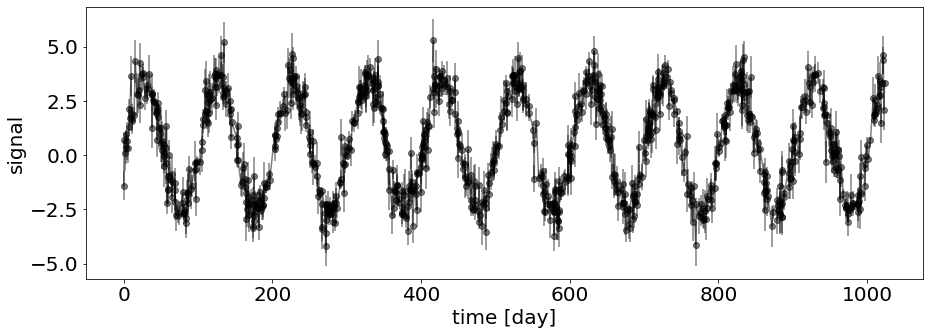

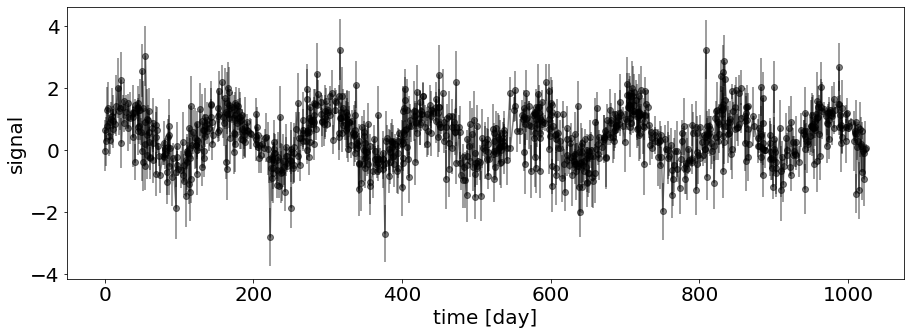

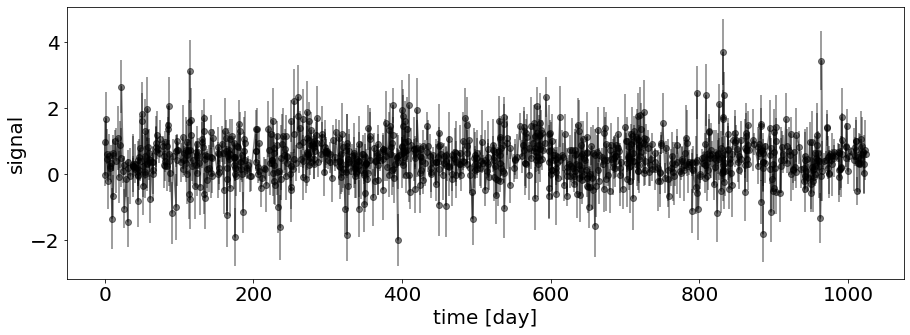

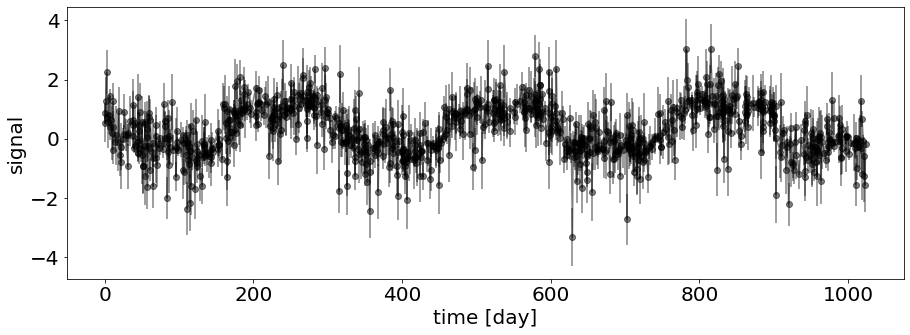

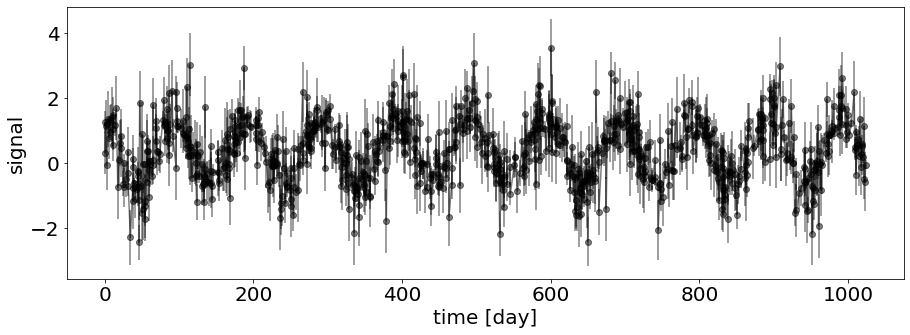

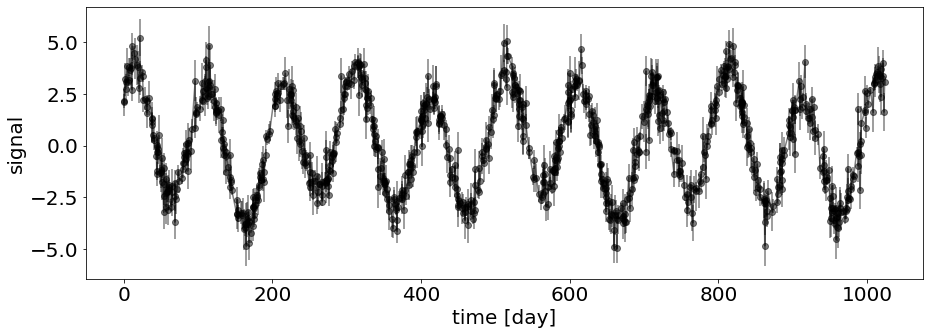

In [3]:
# read in and plot data

data = pd.read_pickle('data/data.pkl').T

t_ar = data[0]
n_obs = len(t_ar)

err = data[1]

data = data[2:]

for i in range(11):
    plt.figure(figsize=(15, 5))
    plt.errorbar(t_ar, data[i], yerr=err,
                 color="k", marker="o", alpha=0.5)
    plt.xlabel('time [day]')
    plt.ylabel('signal')

## 1.) Find 100-day period signal

In [4]:
omega = 2*np.pi/100

a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), np.ones(n_obs)])

cov_inv = (a_mat/err**2).dot(a_mat.T)
cov_inv_null = np.sum(1/err**2)

cov = np.linalg.inv(cov_inv)
cov_null = 1/cov_inv_null

In [5]:
def chi_sq_100(theta, t_ar, data, err, omega = 2*np.pi/100):
    
    a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), np.ones(n_obs)])
    return np.sum(((theta.dot(a_mat) - data)/err)**2)


def chi2_1_freq_op(theta, t_ar, data, err):
    omega = 2*np.pi/theta[-1]
    theta = theta[:-1]
    a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                      np.ones(n_obs)])
    return np.sum(((theta.dot(a_mat) - data)/err)**2)



def chi2_2_freq(theta, t_ar, data, err, omega2, omega = 2*np.pi/100):
    a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                      np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                      np.ones(n_obs)])
    return np.sum(((theta.dot(a_mat) - data)/err)**2, axis = 1)


def chi2_2_freq_op(theta, t_ar, data, err, omega = 2*np.pi/100):
    omega2 = 2*np.pi/theta[-1]
    theta = theta[:-1]
    a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                      np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                      np.ones(n_obs)])
    return np.sum(((theta.dot(a_mat) - data)/err)**2)


def chi2_null(dc, t_ar, data, err):
    return np.sum(((dc - data)/err)**2)

In [6]:
suff_stat = (a_mat/err**2).dot(data.T).T
suff_stat_null = (1/err**2).dot(data.T)

In [7]:
theta = cov.dot(suff_stat.T).T
amp = np.sqrt(theta[:,0]**2 + theta[:,1]**2)

dc = cov_null*suff_stat_null

In [8]:
trial = 1024
amp_boot = np.zeros((trial, 11))
for i in range(trial):
    ind = np.random.choice(range(n_obs), size = n_obs)
    t_boot = t_ar[ind]
    data_boot = data[:,ind]
    err_boot = err[ind]
    
    a_mat_boot = np.array([np.cos(omega*t_boot), np.sin(omega*t_boot), np.ones(n_obs)])

    cov_inv_boot = (a_mat_boot/err_boot**2).dot(a_mat_boot.T)

    cov_boot = np.linalg.inv(cov_inv_boot)
    
    suff_stat_boot = (a_mat_boot/err_boot**2).dot(data_boot.T).T
    
    theta_boot = cov_boot.dot(suff_stat_boot.T).T
    
    amp_boot[i] = np.sqrt(theta_boot[:,0]**2 + theta_boot[:,1]**2)


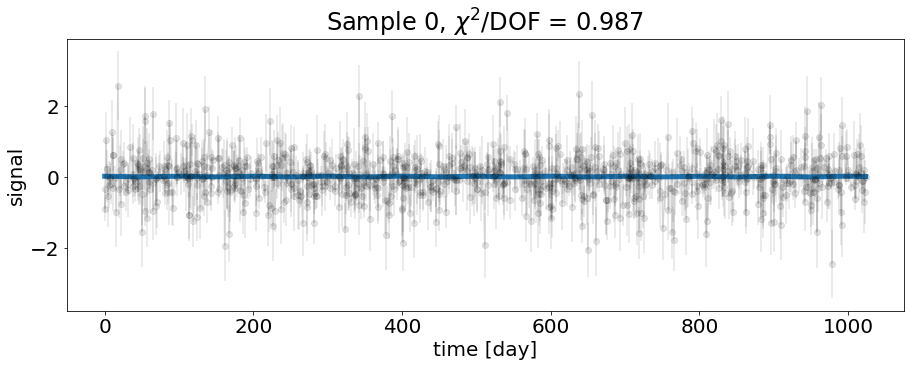

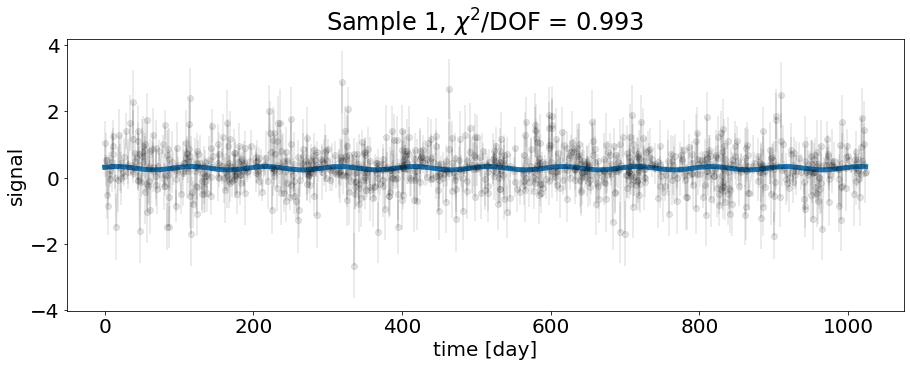

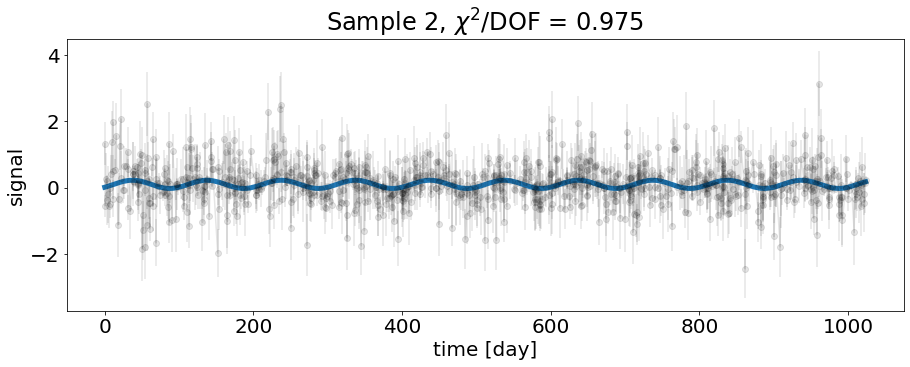

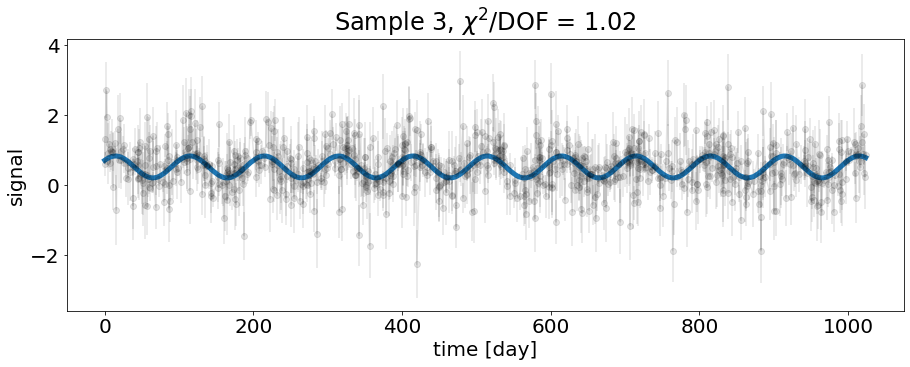

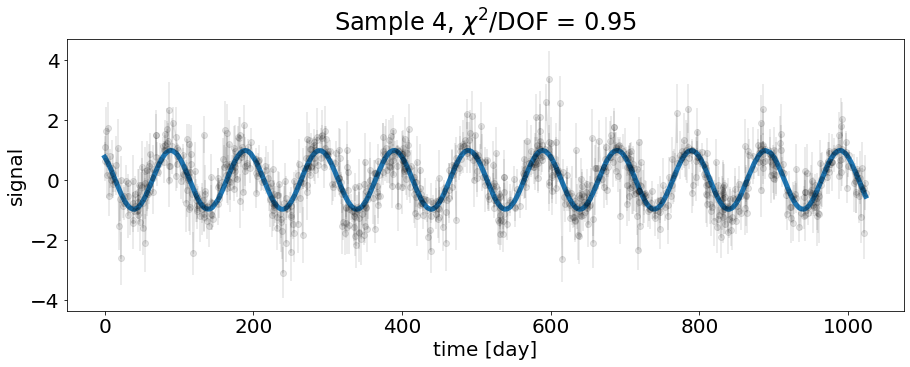

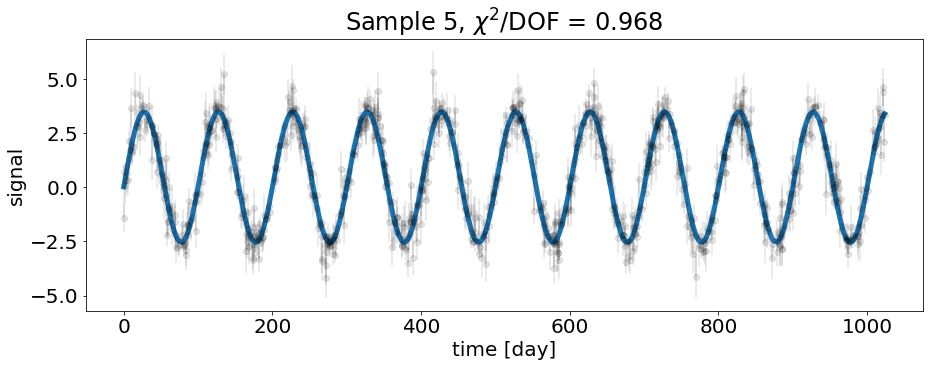

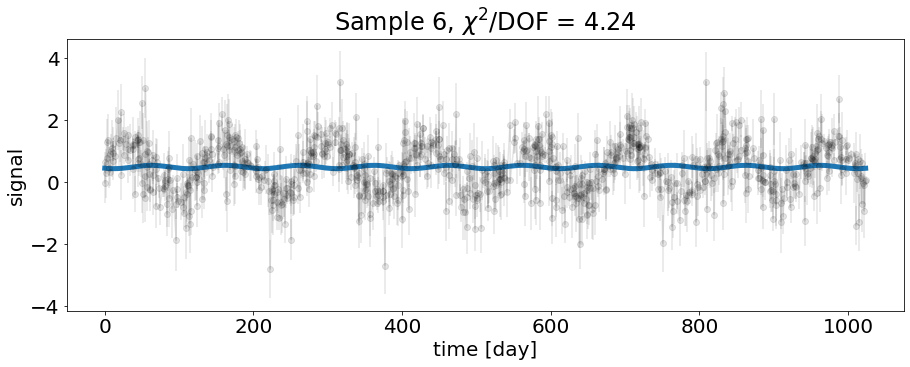

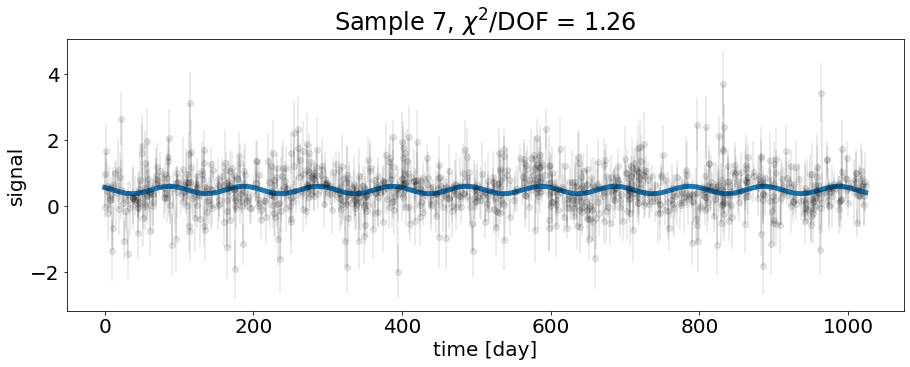

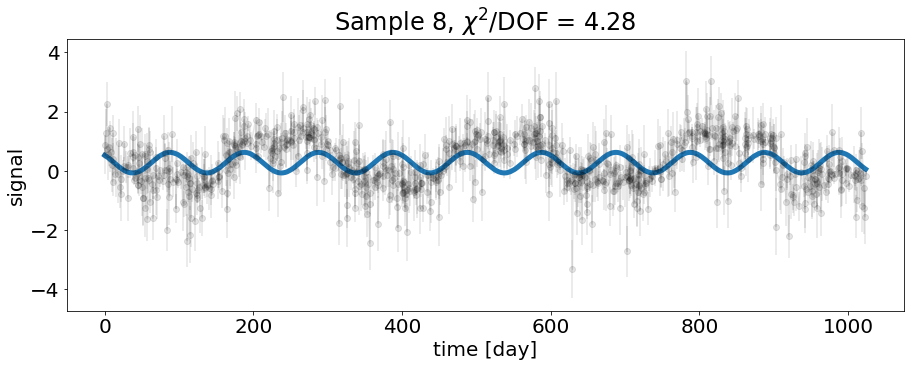

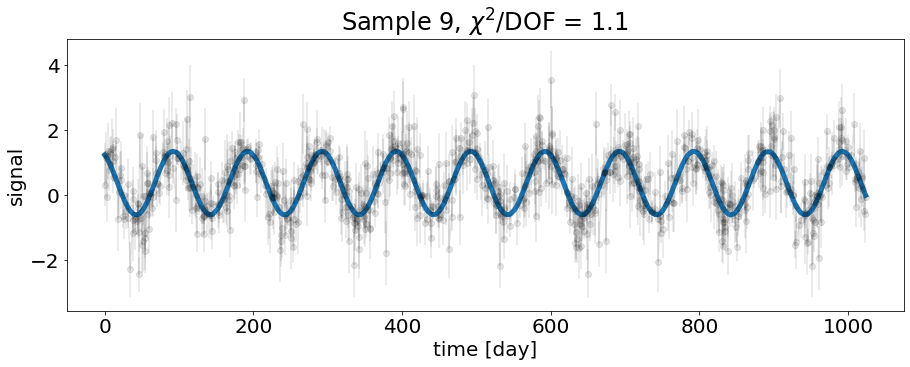

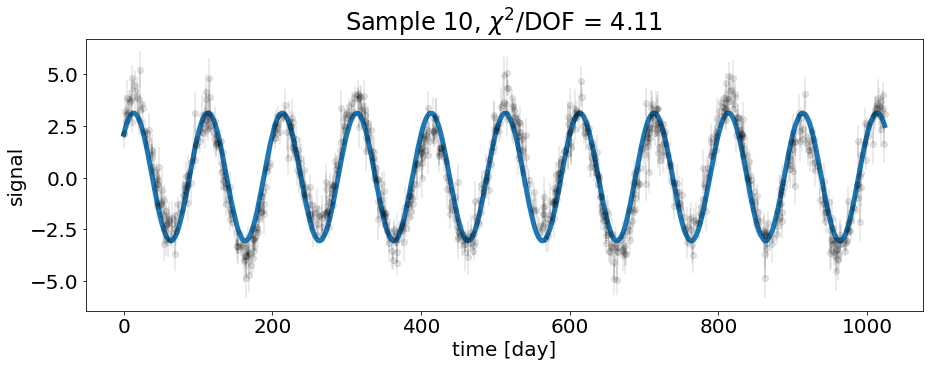

In [9]:
for i in range(11):
    chi = chi_sq_100(theta[i],t_ar, data[i], err)
    plt.figure(figsize=(15, 5))
    plt.errorbar(t_ar, data[i], yerr=err,
                 color="k", marker="o", alpha=0.1)
    plt.plot(t_ar, (a_mat.T).dot(theta[i]), lw = 5)
    #plt.axhline(dc[i - 2], color = 'tab:orange', lw = 5)
    plt.xlabel('time [day]')
    plt.ylabel('signal')
    plt.title(f'Sample {i}, $\chi^2$/DOF = %s' % float('%.3g' % (chi/(n_obs - 3))))

In [10]:
df = pd.DataFrame()
amp_err = np.sqrt(np.mean((amp_boot - amp)**2, axis = 0))

chi = np.zeros(11)
p_val = np.zeros(11)

for i in range(11):
    chi[i] = chi_sq_100(theta[i], t_ar, data[i], err)
    p_val[i] = chi2.sf(chi[i], n_obs -3)

df['Sample'] = range(11)
df['Amplitude'] = amp
df['A_err'] = amp_err
df['SNR'] = amp/amp_err
df['chi^2/DOF'] = chi/(n_obs - 3)
df['p_val'] = p_val
df

,Sample,Amplitude,A_err,SNR,chi^2/DOF,p_val
0,0,0.009008,0.013545,0.665037,0.986726,6.127476e-01
1,1,0.050277,0.013820,3.638049,0.992678,5.600404e-01
2,2,0.123576,0.014154,8.730841,0.974767,7.123308e-01
3,3,0.312987,0.013593,23.026186,1.018526,3.333212e-01
4,4,0.981626,0.013092,74.981124,0.950472,8.693385e-01
5,5,3.007030,0.013692,219.616846,0.967580,7.660138e-01
6,6,0.053871,0.045840,1.175184,4.237706,0.000000e+00
7,7,0.112178,0.018856,5.949227,1.258293,3.111674e-08
8,8,0.348327,0.045744,7.614630,4.284208,0.000000e+00
9,9,0.978126,0.015622,62.611970,1.095521,1.752686e-02


After profiling, we can see that all samples except 0 and 6 have SNR > 3. However, from $\chi^2/DOF$ we can see that sample 6, 7, 8, 10 are not good fits of the 100-day signal. This means that they might contain a second period. As I further explore in the following section.

## 2.) Finding Second Periodic Signal

In [11]:
ind_2 = [6, 7, 8, 10]
data_2 = data[ind_2]
t_tot = t_ar[-1] - t_ar[0]

f_min = .5/t_tot/2*np.pi
f_max = n_obs/t_tot

f_ar = np.arange(f_min, f_max, f_min)
chi2_f = np.zeros((4, len(f_ar)))

for i in range(len(f_ar)):
    omega2 = 2*np.pi*f_ar[i]
    a_mat_2 = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                        np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                        np.ones(n_obs)])
    
    cov_inv_2 = (a_mat_2/err**2).dot(a_mat_2.T)
    cov_2 = np.linalg.inv(cov_inv_2)
    
    suff_stat_2 = (a_mat_2/err**2).dot(data_2.T).T
    theta_2 = cov_2.dot(suff_stat_2.T).T
    
    chi2_f[:,i] = chi2_2_freq(theta_2, t_ar, data_2, err, omega2)

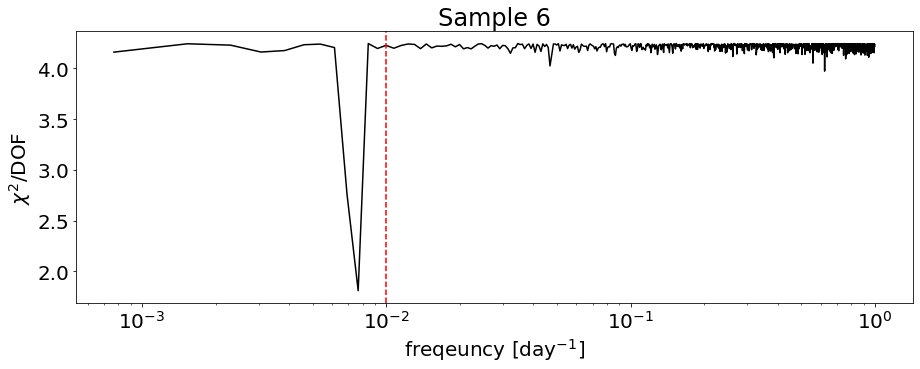

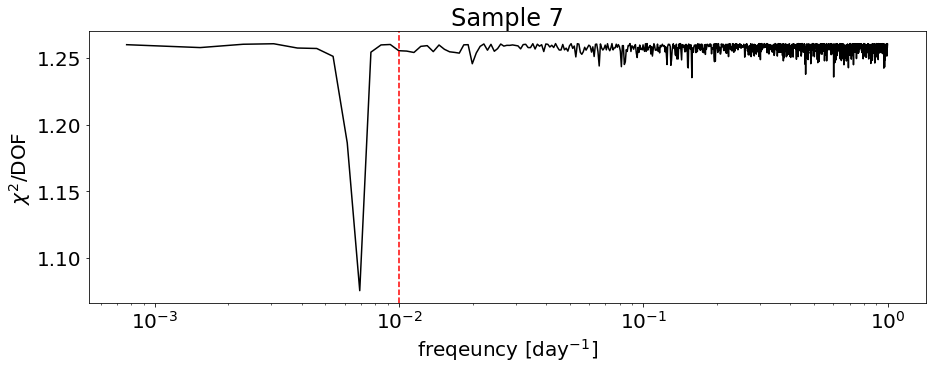

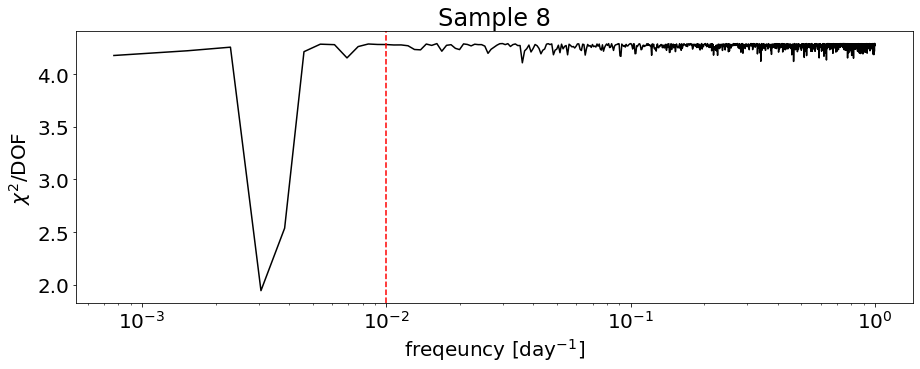

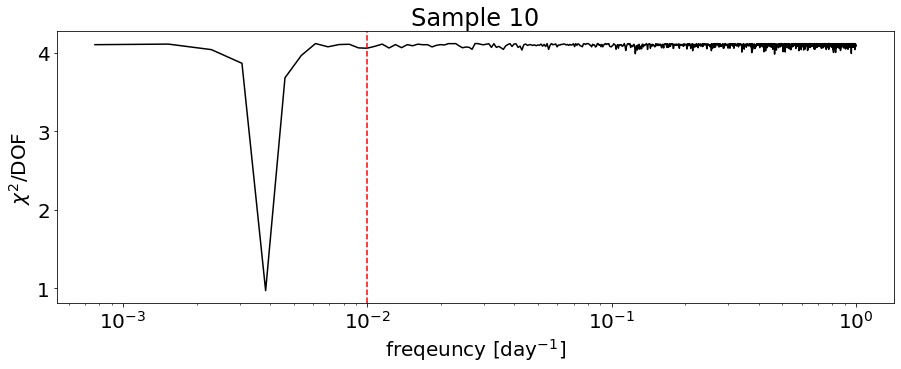

In [12]:
for i in range(4):
    plt.figure(figsize=(15, 5))
    plt.plot(f_ar, chi2_f[i]/(n_obs - 5), color="k")
    plt.axvline(1/100, color = 'r', linestyle = '--')
    plt.xscale('log')
    plt.xlabel('freqeuncy [day$^{-1}$]')
    plt.ylabel('$\chi^2$/DOF')
    plt.title(f'Sample {ind_2[i]}')

We can see that all 4 samples have a minimum in $\chi^2$ at a frequency other than (100 days)$^{-1}$ (shown in red vertical line)

In [13]:
f_max = f_ar[np.argmin(chi2_f, axis = 1)]
sol = []

for i in range(4):
    p0 = np.concatenate([theta_2[i], [1/f_max[i]]])
    sol.append(op.minimize(chi2_2_freq_op, p0, args = (t_ar, data_2[i], err)))

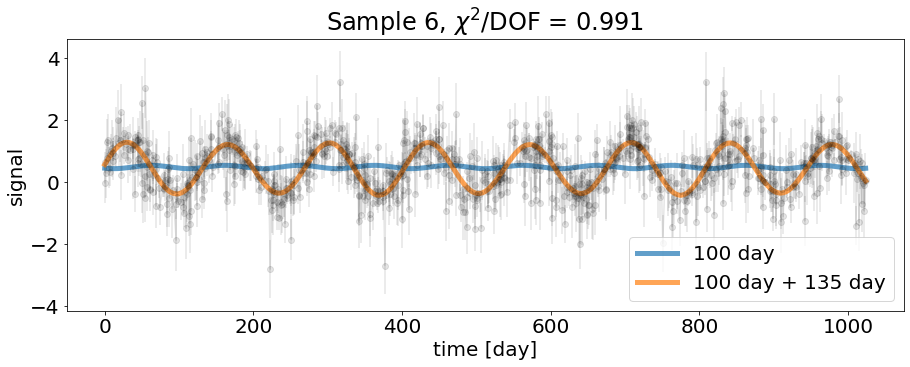

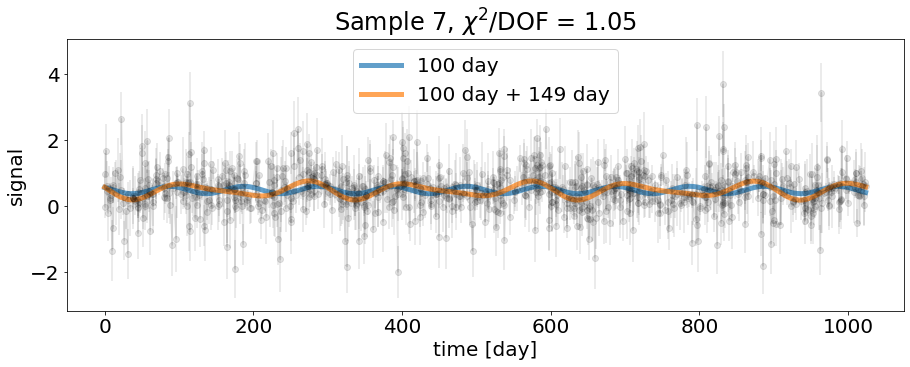

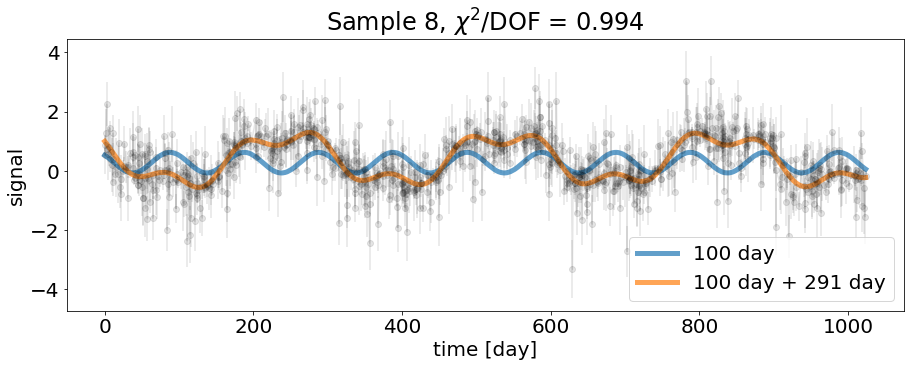

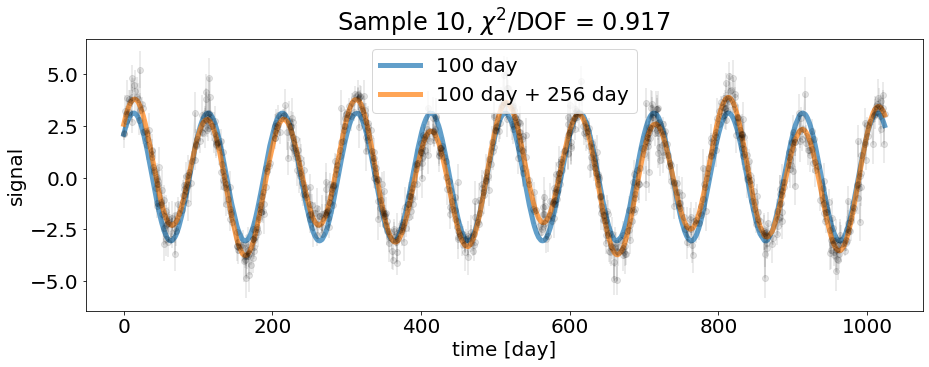

In [14]:
for i in range(4):
    omega2 = 2*np.pi/sol[i].x[-1]
    a_mat_2 = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                        np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                        np.ones(n_obs)])
    plt.figure(figsize=(15, 5))
    plt.errorbar(t_ar, data_2[i], yerr=err,
                 color="k", marker="o", alpha=0.1)
    plt.plot(t_ar, (a_mat.T).dot(theta[ind_2[i]]), lw = 5, alpha = .7, label = '100 day')
    plt.plot(t_ar, (a_mat_2.T).dot(sol[i].x[:-1]), lw = 5, alpha = .7, label = f'100 day + {int(sol[i].x[-1])} day')
    #plt.plot(t_ar, (a_mat.T).dot(theta[ind_2[i]-2]), lw = 5, alpha = .7)
    #plt.axhline(dc[i - 2], color = 'tab:orange', lw = 5)
    plt.xlabel('time [day]')
    plt.ylabel('signal')
    plt.legend()
    plt.title(f'Sample {ind_2[i]}, $\chi^2$/DOF = %s' % float('%.3g' % (sol[i].fun/(n_obs - 6))))

In [15]:
amp_2 = np.zeros(4)
for i in range(4):
    amp_2[i] = np.sqrt(sol[i].x[2]**2 + sol[i].x[3]**2)

In [16]:
trial = 1024
amp_boot_2 = np.zeros((trial, 4))
for i in range(trial):
    
    ind = np.random.choice(range(n_obs), size = n_obs)
    t_boot = t_ar[ind]
    data_boot = data[ind_2][:,ind]
    err_boot = err[ind]
    
    for j in range(4):
        omega2 = 2*np.pi/sol[j].x[-1]
        a_mat_boot_2 = np.array([np.cos(omega*t_boot), np.sin(omega*t_boot), 
                                 np.cos(omega2*t_boot), np.sin(omega2*t_boot), 
                                 np.ones(n_obs)])
        
        cov_inv_boot_2 = (a_mat_boot_2/err_boot**2).dot(a_mat_boot_2.T)
        cov_boot_2 = np.linalg.inv(cov_inv_boot_2)
    
        suff_stat_boot_2 = (a_mat_boot_2/err_boot**2).dot(data_boot[j].T).T
    
        theta_boot_2 = cov_boot_2.dot(suff_stat_boot_2.T).T
        
        amp_boot_2[i][j] = np.sqrt(theta_boot_2[2]**2 + theta_boot_2[3]**2)

In [17]:
df_2 = pd.DataFrame()
amp_2_err = np.sqrt(np.mean((amp_boot_2 - amp_2)**2, axis = 0))

chi_2p = np.zeros(4)
period = np.zeros(4)

for i in range(4):
    chi_2p[i] = sol[i].fun/(n_obs - 6)
    period[i] = sol[i].x[-1]

df_2['Sample'] = ind_2
df_2['Period'] = period
df_2['Amplitude'] = amp_2
df_2['A_err'] = amp_2_err
df_2['SNR'] = amp_2/amp_2_err
df_2['chi^2/DOF'] = chi_2p
df_2

,Sample,Period,Amplitude,A_err,SNR,chi^2/DOF
0,6,135.312131,0.818962,0.013254,61.791796,0.991457
1,7,149.392993,0.206111,0.015246,13.519431,1.050193
2,8,291.384710,0.815352,0.013787,59.138895,0.994390
3,10,256.223398,0.830337,0.014357,57.835297,0.916710


After profiling, we can see that all 4 samples have another signal at a different period all with SNR > 3.

## 3.) 100 Day Signal Strength Treating Signal from 2.) as Nuisances

In [18]:
amp_3 = np.zeros(4)
for i in range(4):
    amp_3[i] = np.sqrt(sol[i].x[0]**2 + sol[i].x[1]**2)

In [19]:
trial = 128
amp_boot_3 = np.zeros((trial, 4))
for i in range(trial):
    
    ind = np.random.choice(range(n_obs), size = n_obs)
    t_boot = t_ar[ind]
    data_boot = data[ind_2][:,ind]
    err_boot = err[ind]
    
    for j in range(4):
        omega2 = 2*np.pi/sol[j].x[-1]
        p0 = sol[j].x
        sol_boot = op.minimize(chi2_2_freq_op, p0, args = (t_boot, data_boot[j], err_boot))
        
        amp_boot_3[i][j] = np.sqrt(sol_boot.x[0]**2 + sol_boot.x[1]**2)

In [20]:
df_3 = pd.DataFrame()
amp_3_err = np.sqrt(np.mean((amp_boot_3 - amp_3)**2, axis = 0))

df_3['Sample'] = ind_2
df_3['Amplitude'] = amp_3
df_3['A_err'] = amp_3_err
df_3['SNR'] = amp_3/amp_3_err
df_3['SNR_part1'] = (amp/amp_err)[ind_2]
df_3

,Sample,Amplitude,A_err,SNR,SNR_part1
0,6,0.040063,0.012015,3.334409,1.175184
1,7,0.098450,0.012781,7.702586,5.949227
2,8,0.320624,0.013181,24.324116,7.614630
3,10,3.015647,0.014060,214.491345,73.144341


As we can see, after treating the parameters from 2.) as nuisance parameters, the SNR for the 100-period day signal increases for all of them. In particular, sample 6 changes from being insignificant (SNR < 3) to significant (SNR > 3)